In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.2


In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
dataset = pd.read_csv('../input/training/Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


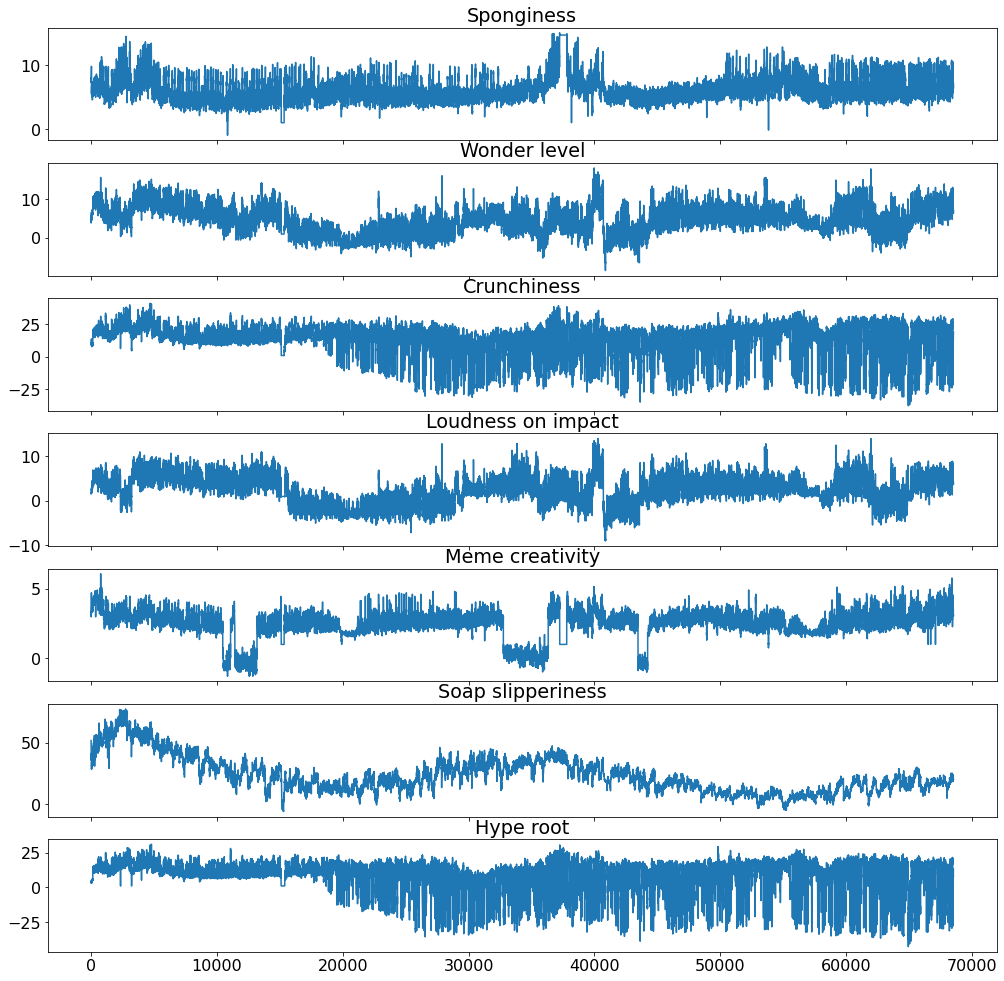

In [5]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

(64728, 7) (3800, 7)


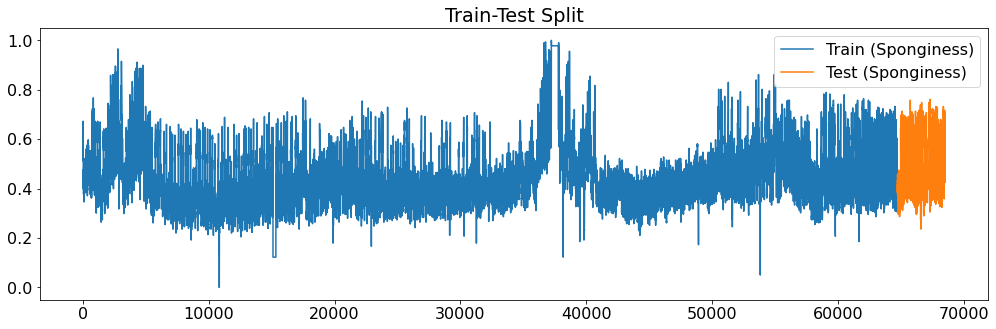

In [6]:
test_size = 3800
X_train_raw = dataset.iloc[:-test_size]
# y_train_raw = y.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]
# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Sponginess, label='Train (Sponginess)')
plt.plot(X_test_raw.Sponginess, label='Test (Sponginess)')
plt.title('Train-Test Split')
plt.legend()
plt.show()


In [7]:
def build_sequences(df, target_labels, window=400, stride=10, telescope=48):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [8]:
target_labels = dataset.columns
window = 400
stride = 10
telescope = 48
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)

In [9]:
#X_train.shape, y_train.shape
X_test.shape, y_test.shape

((356, 400, 7), (356, 48, 7))

In [10]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

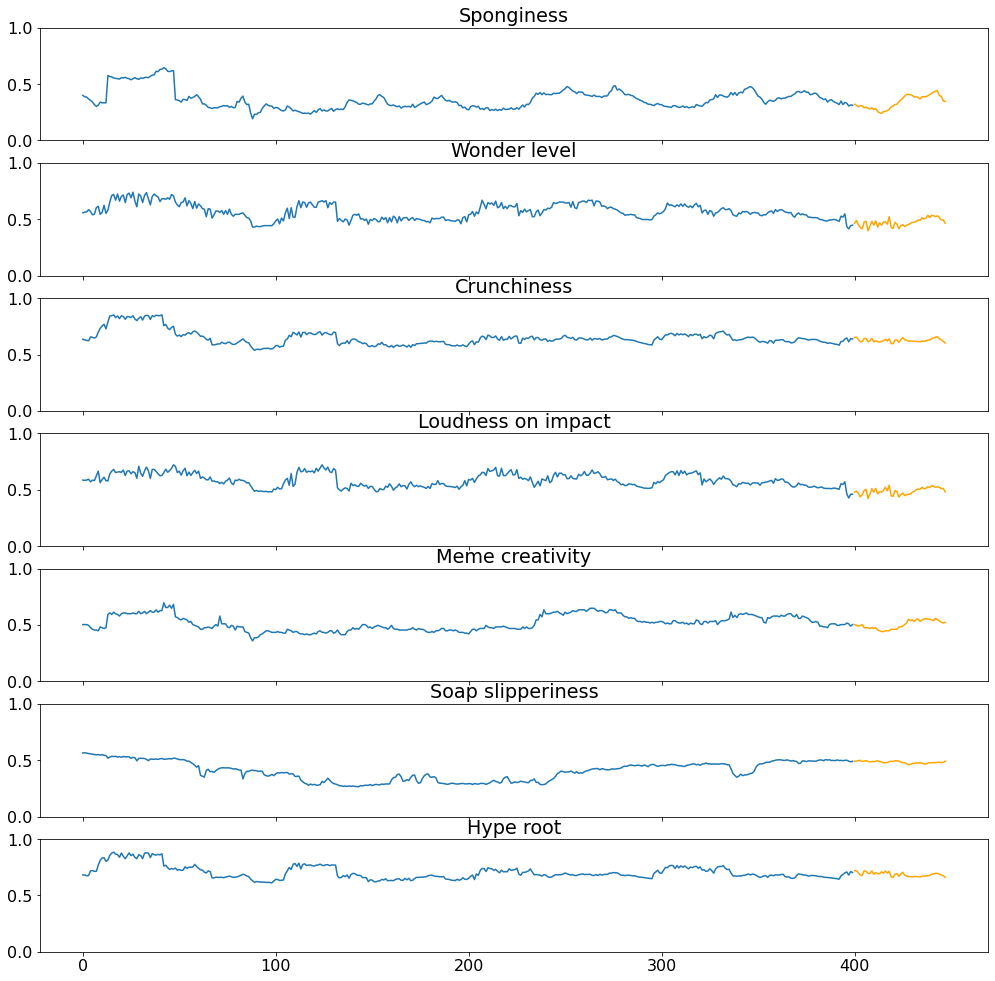

In [11]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [12]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

In [13]:
def build_LSTM(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(input_layer)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(64))(bilstm)
    #dropout = tfkl.Dropout(.5, seed=seed)(bilstm)
    #convlstm = tfkl.GlobalAveragePooling1D()(dropout)
    convlstm = tfkl.Dropout(.5,  seed=seed)(bilstm)

    # Forecasting
    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])
    
    # Return the model
    return model

In [14]:
'''def build_CONV1D_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    cnn = tfkl.Conv1D(32,5,padding='same',activation='relu')(input_layer)
    cnn = tfkl.Conv1D(32,5,padding='same',activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Dropout(.1, seed=seed)(cnn)
   
    cnn = tfkl.Conv1D(64,5,padding='same',activation='relu')(cnn)
    cnn = tfkl.Conv1D(64,5,padding='same',activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Dropout(.1, seed=seed)(cnn)
    
    cnn = tfkl.Conv1D(64,5,padding='same',activation='relu')(cnn)
    cnn = tfkl.Conv1D(64,5,padding='same',activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Dropout(.1, seed=seed)(cnn)
    
    cnn = tfkl.Conv1D(64,5,padding='same',activation='relu')(cnn)
    cnn = tfkl.Conv1D(64,5,padding='same',activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Dropout(.1, seed=seed)(cnn)
    
    cnn = tfkl.Conv1D(64,5,padding='same',activation='relu')(cnn)
    cnn = tfkl.Conv1D(64,5,padding='same',activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Dropout(.1, seed=seed)(cnn)
  
    gap = tfkl.GlobalAveragePooling1D()(cnn)

    # In order to predict the next values for more than one channel,
    # we can use a Dense layer with a number given by telescope*num_channels,
    # followed by a Reshape layer to obtain a tensor of dimension 
    # [None, telescope, num_channels]
    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(gap)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model
    '''

"def build_CONV1D_model(input_shape, output_shape):\n    # Build the neural network layer by layer\n    input_layer = tfkl.Input(shape=input_shape, name='Input')\n    \n    cnn = tfkl.Conv1D(32,5,padding='same',activation='relu')(input_layer)\n    cnn = tfkl.Conv1D(32,5,padding='same',activation='relu')(cnn)\n    cnn = tfkl.MaxPooling1D()(cnn)\n    cnn = tfkl.Dropout(.1, seed=seed)(cnn)\n   \n    cnn = tfkl.Conv1D(64,5,padding='same',activation='relu')(cnn)\n    cnn = tfkl.Conv1D(64,5,padding='same',activation='relu')(cnn)\n    cnn = tfkl.MaxPooling1D()(cnn)\n    cnn = tfkl.Dropout(.1, seed=seed)(cnn)\n    \n    cnn = tfkl.Conv1D(64,5,padding='same',activation='relu')(cnn)\n    cnn = tfkl.Conv1D(64,5,padding='same',activation='relu')(cnn)\n    cnn = tfkl.MaxPooling1D()(cnn)\n    cnn = tfkl.Dropout(.1, seed=seed)(cnn)\n    \n    cnn = tfkl.Conv1D(64,5,padding='same',activation='relu')(cnn)\n    cnn = tfkl.Conv1D(64,5,padding='same',activation='relu')(cnn)\n    cnn = tfkl.MaxPooling1D()(

2022-01-02 11:47:37.202270: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-02 11:47:37.324601: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-02 11:47:37.325906: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-02 11:47:37.328957: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 400, 7)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 400, 128)          36864     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 336)               43344     
_________________________________________________________________
reshape (Reshape)            (None, 48, 7)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 48, 7)             56    

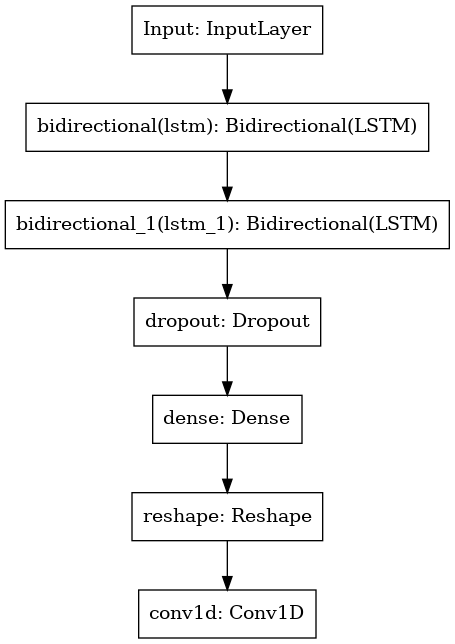

In [15]:
model = build_LSTM(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [16]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

2022-01-02 11:47:42.499398: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-01-02 11:47:49.225077: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


91/91 [==============================] - 23s 106ms/step - loss: 0.0949 - mae: 0.2482 - val_loss: 0.0503 - val_mae: 0.1876
Epoch 2/200
91/91 [==============================] - 8s 91ms/step - loss: 0.0301 - mae: 0.1359 - val_loss: 0.0272 - val_mae: 0.1270
Epoch 3/200
91/91 [==============================] - 8s 90ms/step - loss: 0.0207 - mae: 0.1116 - val_loss: 0.0230 - val_mae: 0.1149
Epoch 4/200
91/91 [==============================] - 8s 89ms/step - loss: 0.0189 - mae: 0.1067 - val_loss: 0.0206 - val_mae: 0.1102
Epoch 5/200
91/91 [==============================] - 8s 88ms/step - loss: 0.0176 - mae: 0.1037 - val_loss: 0.0191 - val_mae: 0.1060
Epoch 6/200
91/91 [==============================] - 8s 90ms/step - loss: 0.0168 - mae: 0.1011 - val_loss: 0.0182 - val_mae: 0.1030
Epoch 7/200
91/91 [==============================] - 8s 89ms/step - loss: 0.0163 - mae: 0.0998 - val_loss: 0.0177 - val_mae: 0.0999
Epoch 8/200
91/91 [==============================] - 8s 91ms/step - loss: 0.0159 - mae

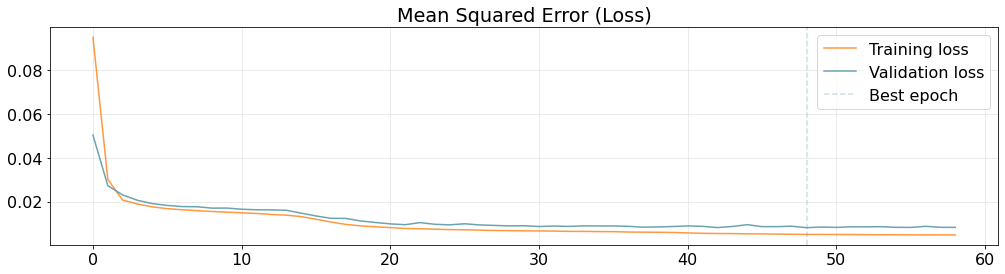

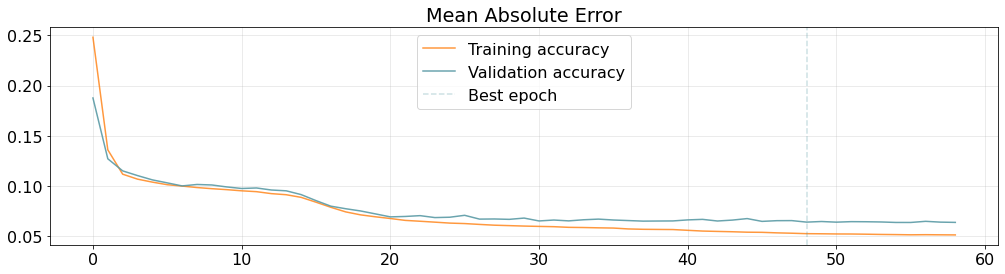

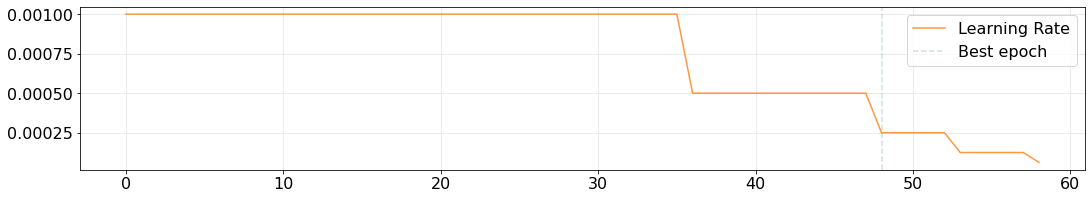

In [17]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [18]:
model.save('AutoregressiveForecastingConvolution')

2022-01-02 11:56:19.325527: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [19]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(356, 48, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.0075093>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.060590774>)

In [20]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

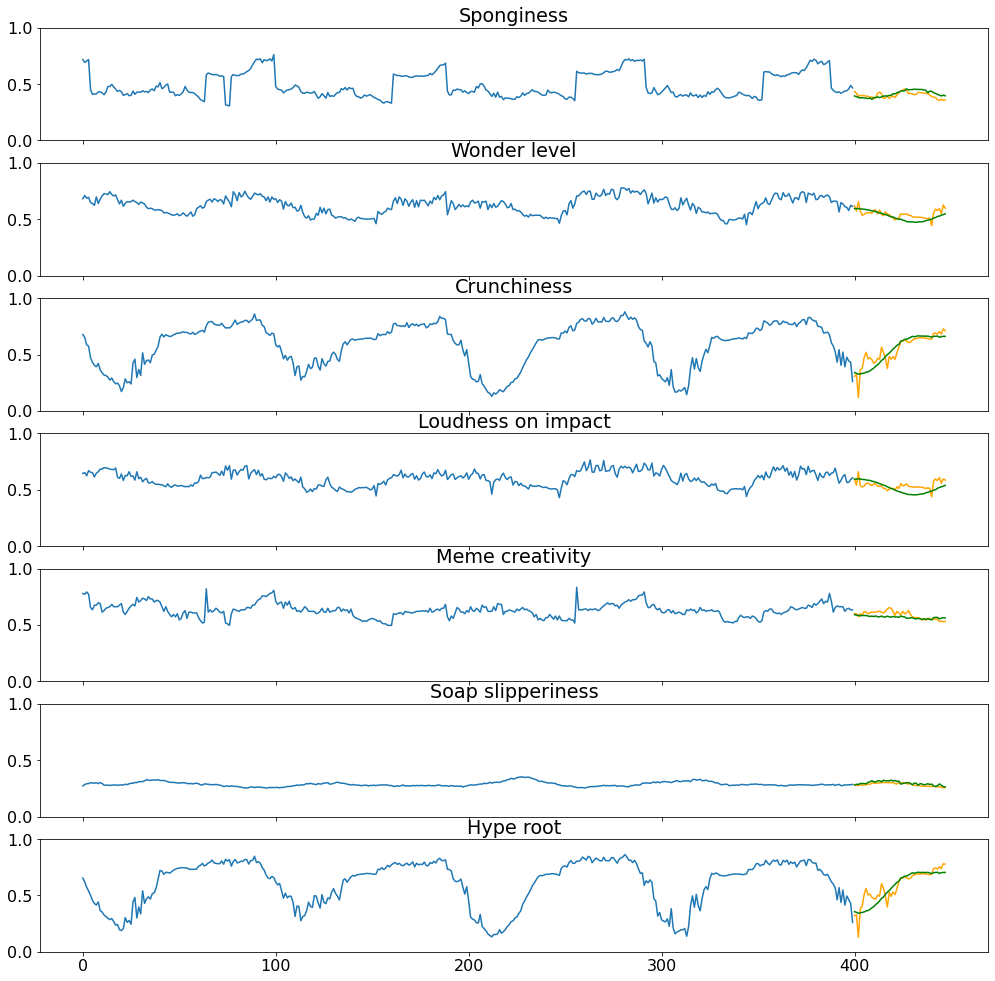

In [21]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

In [22]:
reg_telescope = 864
X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, window, stride, reg_telescope)
X_test_reg.shape, y_test_reg.shape

((274, 400, 7), (274, 864, 7))

In [23]:
# Autoregressive Forecasting
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(0,reg_telescope,telescope):
    pred_temp = model.predict(X_temp)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)

In [24]:
mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.009626271>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.072294205>)

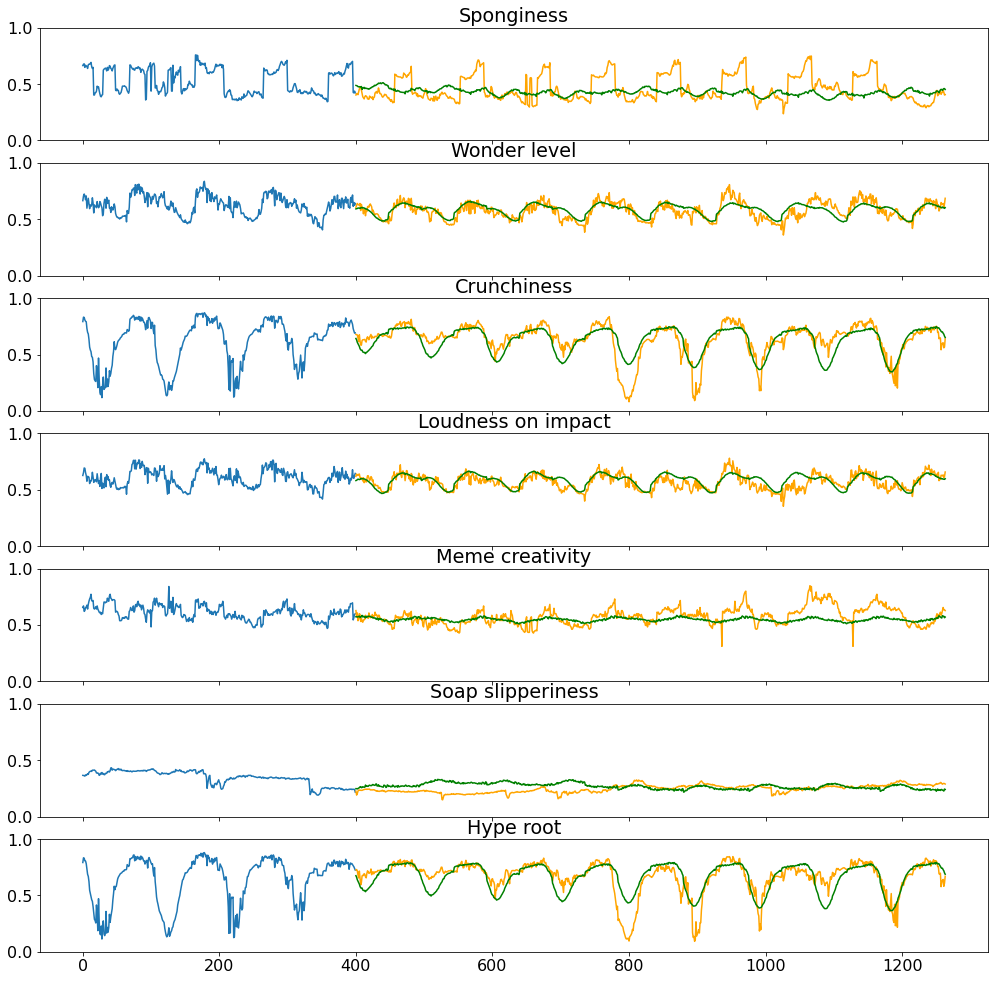

In [25]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, reg_telescope)